In [2]:
import torch
import torch.nn as nn
import skimage
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# Hyperparameters
BATCH_SIZE = 128
FEATURES = 28 * 28
CLASSES = 10
LR = 0.001

# Get image
img = skimage.data.camera().astype('f4')/255
# plt.imshow(img,cmap='gray')

# Encoding help
pointgrid = np.mgrid[:img.shape[0],:img.shape[1]]/len(img)
xy = pointgrid.reshape((2,-1)).T.astype('f4')*2-1
y = img.reshape((-1,1))

# Encode image
def encode(xy=xy, encoding: str = 'raw', L: int = 10):
  if encoding == 'raw':
    return np.array(xy, copy=True)

  # Create array to concatenate additional features to
  # Note: numpy concat in a loop is not efficient
  xy_out = np.empty((xy.shape[0],0))

  # Cycle through frequency 'bands'
  for el in range(0, L):
    val = 2 ** el

    if encoding == "sincos":
      xy_bf = np.sin(val * np.pi * xy)
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

      xy_bf = np.cos(val * np.pi * xy)
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

    if encoding == 'randomfourierfeatures':
      # Retrieve random numbers for basis.
      M_1 = M_1_rands[el]
      phase_shift = phase_shift_rands[el] * np.pi

      xy_bf = np.sin(val * np.matmul(xy, M_1))
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

      # With phase shift
      xy_bf = np.sin(val * np.matmul(xy, M_1) + phase_shift)
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

  return xy_out

xy_encoded = encode(xy=xy, encoding='raw')

# Classes
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=300, output_dim=1):
      super().__init__()
      self.f1 = nn.Linear(input_dim, hidden_dim)
      self.f2 = nn.Linear(hidden_dim, hidden_dim)
      self.f3 = nn.Linear(hidden_dim, hidden_dim)
      self.f4 = nn.Linear(hidden_dim, hidden_dim)
      self.f5 = nn.Linear(hidden_dim, output_dim)
      self.net = nn.Sequential(
         self.f1,
         nn.ReLU(),
         self.f2,
         nn.ReLU(),
         self.f3,
         nn.ReLU(),
         self.f4,
         nn.ReLU(),
         self.f5,
         nn.Sigmoid()
      )
        
    def forward(self, x):
        return self.net(x)

class StitchedMLP(nn.Module):
  def __init__(self, model1 : nn.Module, model2 : nn.Module,
              stitch_idx: int):
    super().__init__()
    self.f1 = deepcopy(model1)
    self.f2 = deepcopy(model2)
    self.f1.eval()
    self.f2.eval()
    self.stitch = nn.Linear(300, 300)
    if stitch_idx == 1:
       self.full = nn.Sequential(
          self.f1.f1,
          nn.ReLU(),
          self.stitch,
          self.f2.f2,
          nn.ReLU(),
          self.f2.f3,
          nn.ReLU(),
          self.f2.f4,
          nn.ReLU(),
          self.f2.f5,
          nn.Sigmoid()
       )
    elif stitch_idx == 2:
       self.full = nn.Sequential(
          self.f1.f1,
          nn.ReLU(),
          self.f1.f2,
          nn.ReLU(),
          self.stitch,
          self.f2.f3,
          nn.ReLU(),
          self.f2.f4,
          nn.ReLU(),
          self.f2.f5,
          nn.Sigmoid()
       )
    elif stitch_idx == 3:
       self.full = nn.Sequential(
          self.f1.f1,
          nn.ReLU(),
          self.f1.f2,
          nn.ReLU(),
          self.f1.f3,
          nn.ReLU(),
          self.stitch,
          self.f2.f4,
          nn.ReLU(),
          self.f2.f5,
          nn.Sigmoid()
       )
    elif stitch_idx == 4:
       self.full = nn.Sequential(
          self.f1.f1,
          nn.ReLU(),
          self.f1.f2,
          nn.ReLU(),
          self.f1.f3,
          nn.ReLU(),
          self.f1.f4,
          nn.ReLU(),
          self.stitch,
          self.f2.f5,
          nn.Sigmoid()
       )
    

  def forward(self, x):
    return self.full(x)

In [6]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

xy_tensor = torch.tensor(xy_encoded, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

fullset = TensorDataset(xy_tensor, y_tensor)
odd_idx = list(range(0, len(fullset), 2))
even_idx = list(range(1, len(fullset), 2))

trainset = Subset(fullset, even_idx)
testset = Subset(fullset, odd_idx)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

"""
epochs = 15

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch_coords, batch_vals in trainloader:
        # Forward
        pred_vals = model(batch_coords)
        loss = criterion(pred_vals, batch_vals)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    epoch_loss = running_loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
"""

'\nepochs = 15\n\nmodel = MLP()\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=1e-3)\n\nmodel.train()\nfor epoch in range(epochs):\n    running_loss = 0.0\n    for batch_coords, batch_vals in trainloader:\n        # Forward\n        pred_vals = model(batch_coords)\n        loss = criterion(pred_vals, batch_vals)\n        \n        # Backprop\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        \n        running_loss += loss.item()\n    epoch_loss = running_loss\n    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")\n'

In [7]:
def train(model, epochs, trainloader=trainloader,
          stitch=False):
    if stitch:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.stitch.parameters():
            param.requires_grad = True
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_coords, batch_vals in trainloader:
            # Forward
            pred_vals = model(batch_coords)
            loss = criterion(pred_vals, batch_vals)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        epoch_loss = running_loss
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

In [8]:
def test(model, testloader=testloader):
    criterion = nn.MSELoss()
    running_loss = 0
    for coord, vals in testloader:
        outputs = model(coord)
        loss = criterion(outputs, vals)
        running_loss += loss.item()
    return running_loss

def test_show(model, xy=xy):
    model.eval()
    with torch.no_grad():
        # Predict for all pixel coordinates
        pred_vals = model(torch.tensor(xy)).cpu().numpy().reshape(img.shape[0], img.shape[1])

    # 5. Visualize the reconstructed image
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(pred_vals, cmap='gray')
    axes[1].set_title("Reconstructed from MLP")
    axes[1].axis('off')
    plt.show()

In [92]:
# Train with RFF
xy_rff = encode(xy, 'rff')
xy_tensor = torch.tensor(xy_rff, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

fullset = TensorDataset(xy_tensor, y_tensor)
odd_idx = list(range(0, len(fullset), 2))
even_idx = list(range(1, len(fullset), 2))

trainset = Subset(fullset, even_idx)
testset = Subset(fullset, odd_idx)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

RFF_MLP = MLP(input_dim=xy_rff.shape[1])
train(RFF_MLP, 10, trainloader=trainloader)
test_show(RFF_MLP, xy_rff)


Epoch [1/10], Loss: 170.7067
Epoch [2/10], Loss: 170.6531
Epoch [3/10], Loss: 170.6608
Epoch [4/10], Loss: 170.6594
Epoch [5/10], Loss: 170.6595
Epoch [6/10], Loss: 170.6559
Epoch [7/10], Loss: 170.6626
Epoch [8/10], Loss: 170.6605
Epoch [9/10], Loss: 170.6577
Epoch [10/10], Loss: 170.6576


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [16]:
A = MLP()
B = MLP()
G = StitchedMLP(A, B, 1)
train(G, 20, stitch=True)
test_show(G)

KeyboardInterrupt: 

In [9]:
# Train with raw encoding
layers = [1, 2, 3, 4]
trials = 5
results = np.zeros((3, len(layers), trials))
penalties = [0] * 4
models = [[0] * 3] * 4

EPOCHS_1 = 10
EPOCHS_2 = 10
for i, l in enumerate(layers):
    for t in range(trials):
        Rand = MLP()
        ToTrainA = MLP()
        ToTrainB = MLP()
        train(ToTrainA, EPOCHS_1)
        train(ToTrainB, EPOCHS_1)
        GoodStitched = StitchedMLP(ToTrainA, ToTrainB, l)
        BadStitched = StitchedMLP(Rand, ToTrainB, l)
        train(GoodStitched, EPOCHS_2, stitch=True)
        train(BadStitched, EPOCHS_2, stitch=True)
        results[0, i, t] = test(GoodStitched)
        results[1, i, t] = test(BadStitched)
        results[2, i, t] = test(ToTrainB)

Epoch [1/10], Loss: 30.5296
Epoch [2/10], Loss: 21.8083
Epoch [3/10], Loss: 19.6864
Epoch [4/10], Loss: 18.3511
Epoch [5/10], Loss: 17.3914
Epoch [6/10], Loss: 16.3978
Epoch [7/10], Loss: 15.6550
Epoch [8/10], Loss: 15.3209
Epoch [9/10], Loss: 14.7678
Epoch [10/10], Loss: 14.4241
Epoch [1/10], Loss: 30.4707
Epoch [2/10], Loss: 21.6592
Epoch [3/10], Loss: 19.6411
Epoch [4/10], Loss: 18.0443
Epoch [5/10], Loss: 17.0663
Epoch [6/10], Loss: 16.3232
Epoch [7/10], Loss: 15.5300
Epoch [8/10], Loss: 15.0572
Epoch [9/10], Loss: 14.6483
Epoch [10/10], Loss: 14.0970
Epoch [1/10], Loss: 35.4028
Epoch [2/10], Loss: 26.9584
Epoch [3/10], Loss: 25.4865
Epoch [4/10], Loss: 23.4425
Epoch [5/10], Loss: 22.0631
Epoch [6/10], Loss: 21.3111
Epoch [7/10], Loss: 21.3764
Epoch [8/10], Loss: 20.8864
Epoch [9/10], Loss: 20.8231
Epoch [10/10], Loss: 20.5773
Epoch [1/10], Loss: 40.4016
Epoch [2/10], Loss: 31.1175
Epoch [3/10], Loss: 29.1137
Epoch [4/10], Loss: 27.6304
Epoch [5/10], Loss: 26.5903
Epoch [6/10], Los

KeyboardInterrupt: 

In [90]:
# Train with RFF


[[17.2361271  11.95670823 11.03424812 13.15567858]
 [20.8634189  21.52533213 23.53884163 33.50964806]
 [18.14798374 14.16821555 14.66681975 14.41338732]]


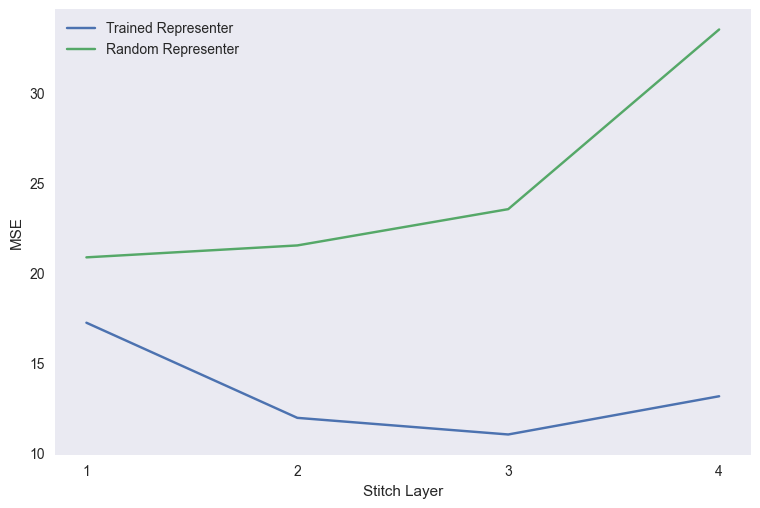

In [101]:
from matplotlib.ticker import MaxNLocator
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots()
plt.grid(False)
ax.plot(layers, results[0, :], label='Trained Representer', marker='o')
ax.plot(layers, results[1, :], label='Random Representer', marker='o')
ax.set_xlabel('Stitch Layer')
ax.set_ylabel('MSE')
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
print(results)

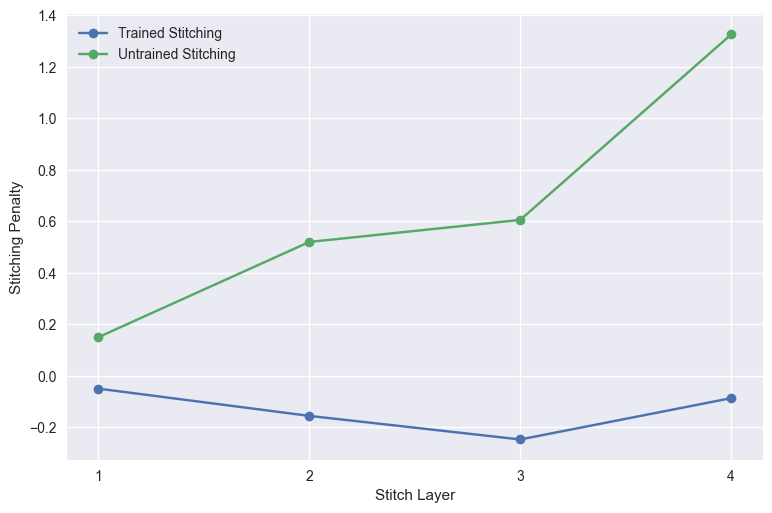

In [102]:
good_penalties = (results[0, :] - results[2, :])/results[2, :]
bad_penalties = (results[1, :] - results[2, :])/results[2, :]

fig, ax = plt.subplots()
ax.plot(layers, good_penalties, marker='o', label='Trained Stitching')
ax.plot(layers, bad_penalties, marker='o', label='Untrained Stitching')
ax.set_xlabel('Stitch Layer')
ax.set_ylabel('Stitching Penalty')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()

Random Representation 1
Random Representation 2
Random Representation 3
Random Representation 4
Trained Representation 1
Trained Representation 2
Trained Representation 3
Trained Representation 4
Unstitched 1
Unstitched 2
Unstitched 3
Unstitched 4


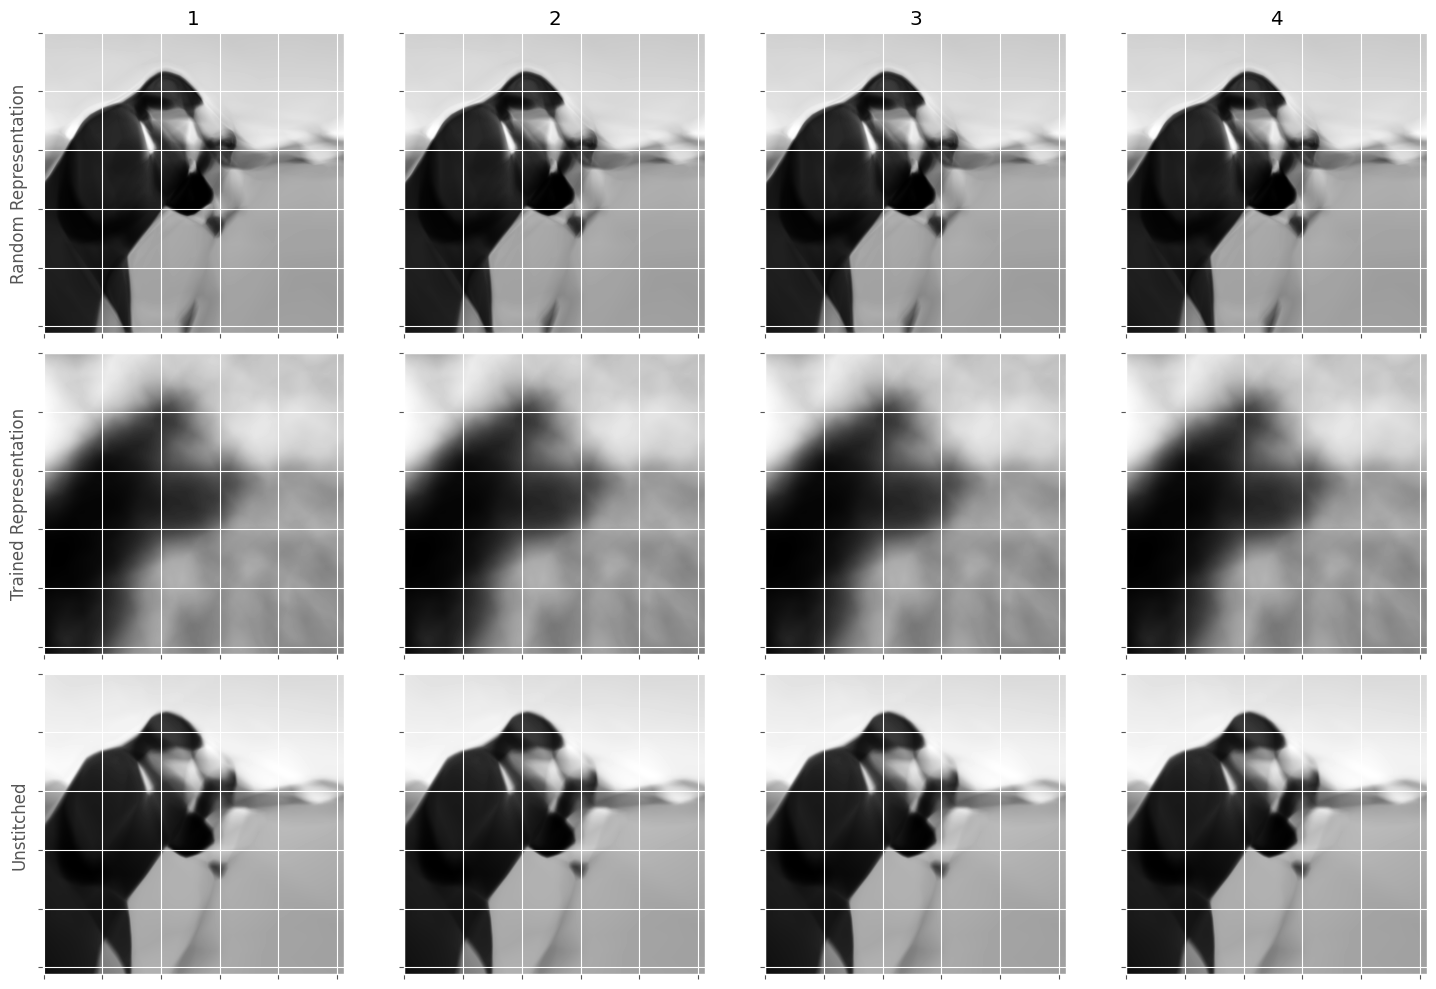

In [77]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
stitch_types = ['Random Representation', 'Trained Representation',
                'Unstitched']

for i, s in enumerate(stitch_types):
    for j, l in enumerate(layers):
        model = models[j][i]
        model.eval()
        with torch.no_grad():
            # Predict for all pixel coordinates
            pred_vals = model(torch.tensor(xy)).cpu().numpy().reshape(img.shape[0], img.shape[1])
        axs[i][j].imshow(pred_vals, cmap='gray')
        axs[i][j].set_xticklabels([])
        axs[i][j].set_yticklabels([])
        if j == 0:
            axs[i][j].set_ylabel(s)
        if i == 0:
            axs[i][j].set_title(l)
        print(s + ' ' + str(l))
plt.tight_layout()

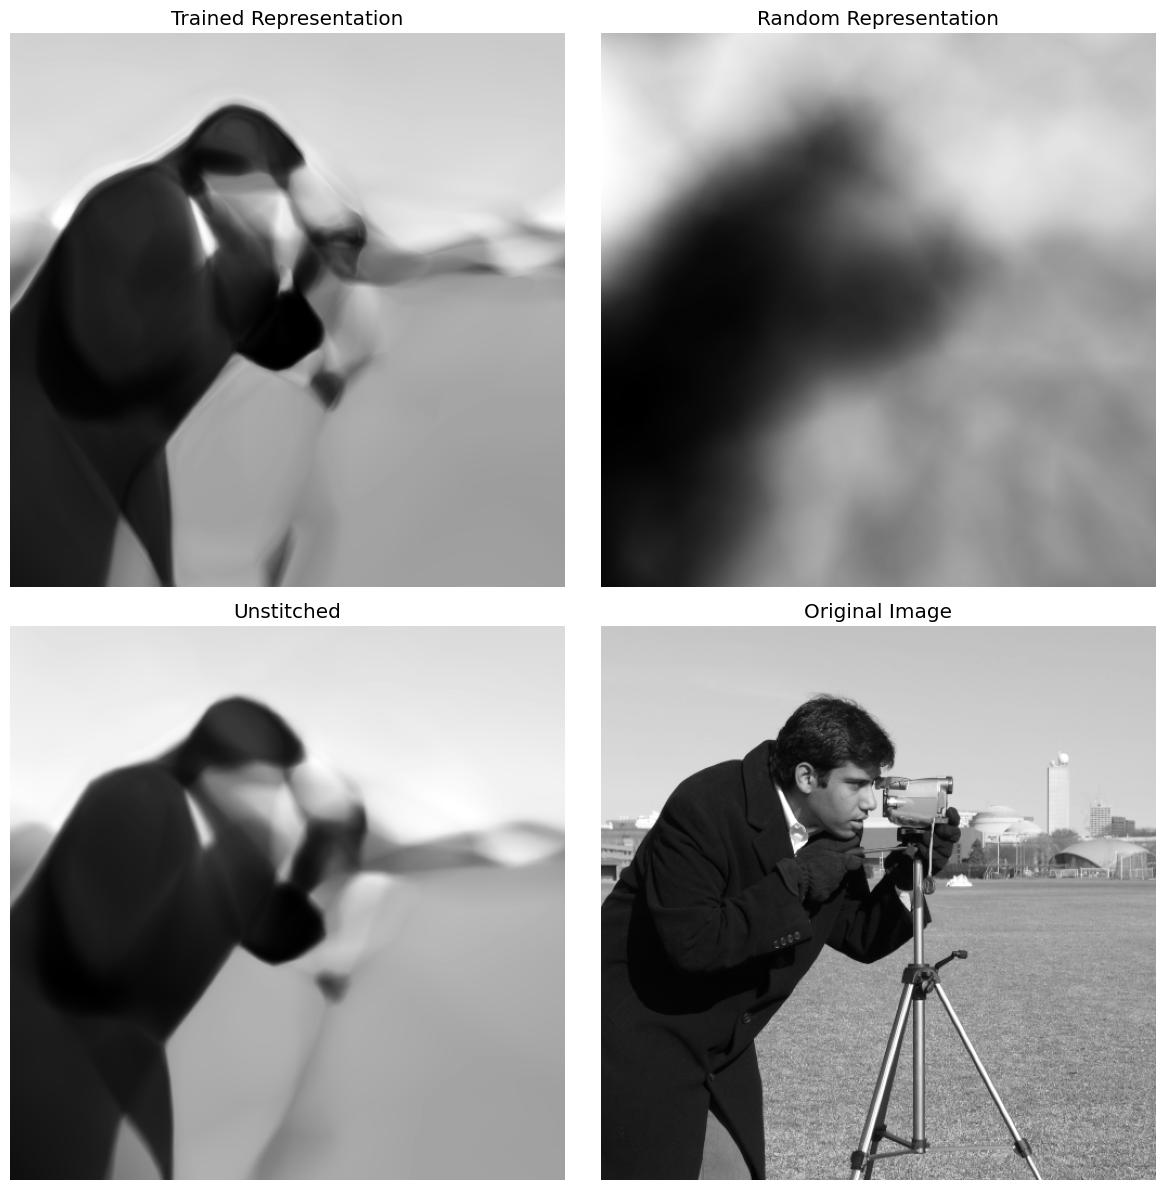

In [89]:
plt.style.use('ggplot')
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.flatten()
titles = ['Trained Representation', 'Random Representation',
          'Unstitched', 'Original Image']
for i, a in enumerate(ax):
    if i == 3:
        a.imshow(img, cmap='gray')
        a.axis(False)
        a.set_title(titles[i])
    else:
        model = models[1][i]
        with torch.no_grad():
            # Predict for all pixel coordinates
            pred_vals = model(torch.tensor(xy)).cpu().numpy().reshape(img.shape[0], img.shape[1])
        a.imshow(pred_vals, cmap='gray')
        a.axis(False)
        a.set_title(titles[i])
plt.tight_layout()

(-0.5, 511.5, 511.5, -0.5)

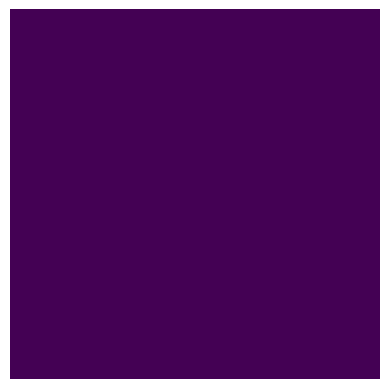

In [78]:
with torch.no_grad():
        # Predict for all pixel coordinates
        pred1 = models[0][0](torch.tensor(xy)).cpu().numpy().reshape(img.shape[0], img.shape[1])
        pred2 = models[3][0](torch.tensor(xy)).cpu().numpy().reshape(img.shape[0], img.shape[1])
plt.imshow(pred2 - pred1, cmap='viridis')
plt.axis(False)